## PREAMBLE

In [15]:
import numpy as np
from scipy.stats import multivariate_normal, norm
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
import seaborn as sns

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [1]:
# 1. Helper Functions
def initialize_parameters(X, K):
    N, D = X.shape
    np.random.seed(42)
    indices = np.random.choice(N, K, replace=False)
    mu = X[indices]
    sigma = [np.eye(D) for _ in range(K)]
    pi = np.ones(K) / K
    return mu, sigma, pi

def e_step(X, mu, sigma, pi):
    N, K = X.shape[0], len(mu)
    gamma = np.zeros((N, K))
    for k in range(K):
        gamma[:, k] = pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=sigma[k])
    gamma /= gamma.sum(axis=1, keepdims=True)
    return gamma

def m_step(X, gamma):
    N, D = X.shape
    K = gamma.shape[1]
    N_k = gamma.sum(axis=0)
    mu = np.array([np.sum(gamma[:, k][:, np.newaxis] * X, axis=0) / N_k[k] for k in range(K)])
    sigma = []
    for k in range(K):
        diff = X - mu[k]
        cov_k = (gamma[:, k][:, np.newaxis] * diff).T @ diff / N_k[k]
        sigma.append(cov_k)
    pi = N_k / N
    return mu, sigma, pi

def compute_log_likelihood(X, mu, sigma, pi):
    N = X.shape[0]
    log_likelihood = 0
    for i in range(N):
        temp = 0
        for k in range(len(mu)):
            temp += pi[k] * multivariate_normal.pdf(X[i], mean=mu[k], cov=sigma[k])
        log_likelihood += np.log(temp)
    return log_likelihood

def gmm_em(X, K, max_iters=100, tol=1e-4):
    mu, sigma, pi = initialize_parameters(X, K)
    log_likelihoods = []

    for i in range(max_iters):
        gamma = e_step(X, mu, sigma, pi)
        mu, sigma, pi = m_step(X, gamma)
        log_likelihood = compute_log_likelihood(X, mu, sigma, pi)
        log_likelihoods.append(log_likelihood)

        if i > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return mu, sigma, pi, gamma, log_likelihoods

## MAIN

[[ 5.07986214]
 [-0.05227488]]
[array([[0.97232955]]), array([[0.83088056]])]
[0.50170591 0.49829409]


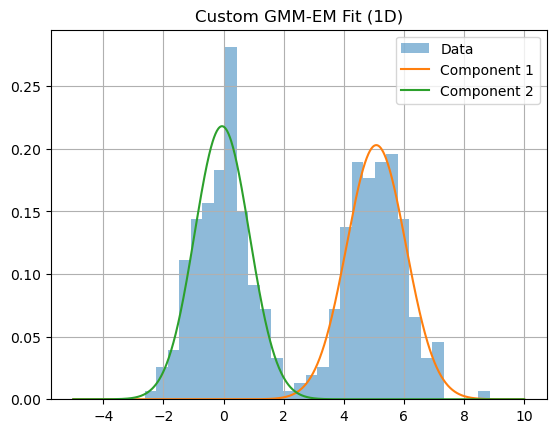

In [11]:
# 2. Generate 1-D Data
np.random.seed(42)
x1 = np.random.normal(0, 1, 200)
x2 = np.random.normal(5, 1, 200)
X_1d = np.concatenate([x1, x2]).reshape(-1, 1)

# 3. Run custom GMM-EM on 1-D Data
mu_1d, sigma_1d, pi_1d, gamma_1d, ll_1d = gmm_em(X_1d, K=2)
print(mu_1d,sigma_1d, pi_1d,sep='\n')
# Plot the 1-D histogram with fitted components
x_plot = np.linspace(-5, 10, 1000)
plt.hist(X_1d, bins=30, density=True, alpha=0.5, label="Data")
for k in range(2):
    plt.plot(x_plot, pi_1d[k] * norm.pdf(x_plot, loc=mu_1d[k][0], scale=np.sqrt(sigma_1d[k][0, 0])), label=f"Component {k+1}")
plt.legend()
plt.title("Custom GMM-EM Fit (1D)")
plt.grid(True)
plt.show()

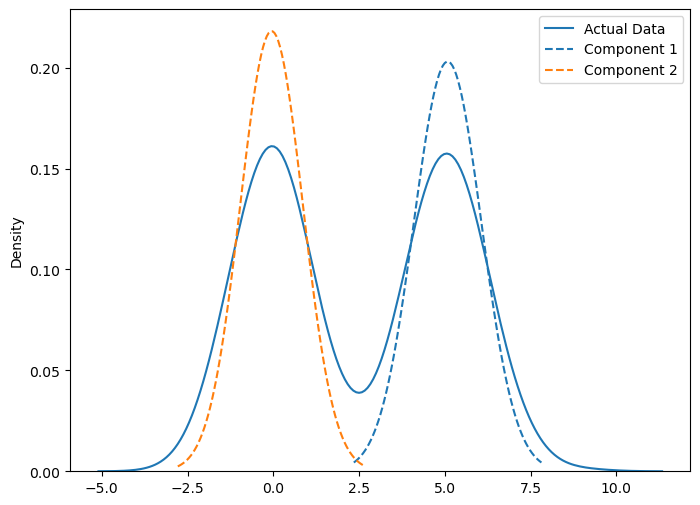

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(X_1d, color='black', label='Actual Data', common_norm=False, lw=1.5, ax=ax)
for i in range(2):
    x = np.linspace(mu_1d[i] - 3 * np.sqrt(sigma_1d[k][0, 0]),
                    mu_1d[i] + 3 * np.sqrt(sigma_1d[k][0, 0]), 100)
    pdf = norm.pdf(x, loc=mu_1d[i], scale=np.sqrt(sigma_1d[i]))
    plt.plot(x, pdf * pi_1d[i], label=f'Component {i+1}', linestyle='--')
    
plt.legend()

C:\Users\vanto\anaconda3\envs\model_dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


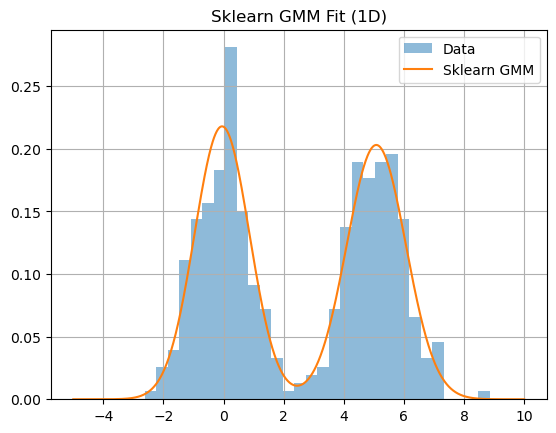

In [17]:
# 4. Compare with sklearn's GaussianMixture
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_1d)
x_sklearn = np.linspace(-5, 10, 1000)
y_sklearn = np.exp(gmm.score_samples(x_sklearn.reshape(-1, 1)))

plt.hist(X_1d, bins=30, density=True, alpha=0.5, label="Data")
plt.plot(x_sklearn, y_sklearn, label="Sklearn GMM")
plt.legend()
plt.title("Sklearn GMM Fit (1D)")
plt.grid(True)
plt.show()